In [41]:
import math
import sys
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pprint
from feature_format import featureFormat, targetFeatureSplit
sys.path.append("../tools/")

with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)


### Overview

In 2000, a company named Enron was one of the largest companies in the United States. Based in Houston, they became one of the worlds major energy and commodoties companies. Corporate fraud spread throughout the company and eventually led to their downfall, causing them to collapse into bankruptcy in 2002. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives.

>Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?

The goal of this project is to use that financial and email data that was made available to determine if an employee has committed fraud. These people will be known as POI's(persons of interest). This means they are in one of the following categories: indicted, settled or plea deal with the government, or testified in exchange for prosecution immunity.

## Data Exploration

| Description | Result |
|----------- | ------|
|Number of People| 146|
|Number of People of Interest| 18 |
|Number of Features | 21 |

With a total of 146 people, each person in the dataset has 21 different features that might be used to determine whether a person is a POI or not. These features can be split into three categories; financial, email, and if they were actually a POI. These features are:

**Email Features**: `[to_messages, email_address, from_poi_to_this_person, from_messages, from_this_person_to_poi, shared_receipt_with_poi]`

**Financial Features**: `[salary, deferral_payments, total_payments, loan_advances, bonus, restricted_stock_deferred, deferred_income, total_stock_value, expenses, exercised_stock_options, other, long_term_incentive, restricted_stock, director_fees]`

**Target Label**: `[poi]`

### Missing Data

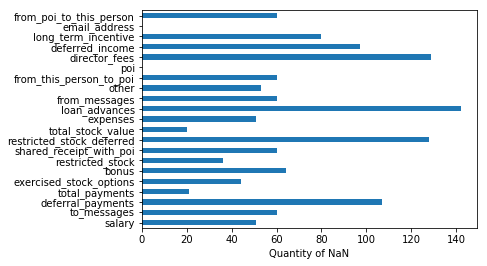

In [42]:
df = pd.DataFrame.from_dict(data_dict, orient='index', dtype=np.float)
dfNull = df.isnull().sum()
dfNull.plot(kind='barh')
plt.xlabel('Quantity of NaN')
plt.show()

The Enron dataset has quite a few missing values that can be seen in the plot above. All features have some quantity of values missing. In order to use these features in training algorithms, the NaN values will be considered as 0.

### Outliers

Plotting the data showed an obvious outlier that ended up being the total of all people. Once removed, there was a much more clear spread of points. Any other outliers were kept in the dataset because they were the people in top positions at Enron.

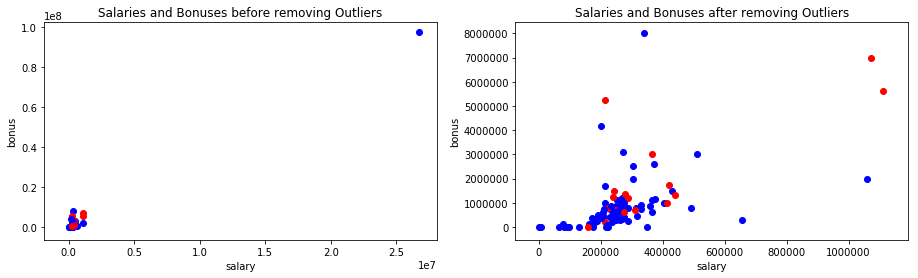

In [43]:
def plotData(data_dict, features):
    '''
    Plot features denoting poi's by color
    '''
    data = featureFormat(data_dict, features)
    poi_colors = ['b', 'r']
    for point in data:
        plt.scatter(point[1], point[2], c=poi_colors[int(point[0])])

    plt.xlabel(features[1])
    plt.ylabel(features[2])
    
features = ['poi', 'salary', 'bonus']
plt.subplot(121)
plt.title('Salaries and Bonuses before removing Outliers')
plotData(data_dict, features)

plt.subplot(122)
data_dict.pop('TOTAL', 0)
data_dict.pop('THE TRAVEL AGENCY IN THE PARK', 0)
plt.title('Salaries and Bonuses after removing Outliers')
plotData(data_dict, features)

plt.subplots_adjust(left=-1, right=1)
plt.show()

## Feature Selection

>What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. 

Before deciding which features to use, I created some new ones that may help to identify POI's. These features relate some factors that I think may have an impact on the model. 

**ratio_from_poi**: from_poi_to_this_person/to_messages
This feature is the ratio of emails that were sent to this peron from a POI and all of the messages that were sent to this person

**ratio_to_poi**: from_this_person_to_poi/from_messages
This feature is the ratio of emails sent from this person to a POI and all of the messages sent from this person

**ratio_exercised_stock_tot_stock_value**: exercised_stock_options/total_stock_value
This feature is the ratio of how much stock the person exercised to how much stock they had

To find what the best features are for training the algorithm, I used the SelectKBest funtion. This gave each feature a value of importance to identifying a POI. The list of features by performance:

|Feature|Score|
|----|----|
|exercised_stock_options| 24.815079733218194|
|total_stock_value|24.182898678566879|
|bonus|20.792252047181535|
|salary|18.289684043404513|
|ratio_to_poi|16.409712548035792|
|deferred_income|11.458476579280369|
|long_term_incentive|9.9221860131898225|
|restricted_stock|9.2128106219771002|
|total_payments|8.7727777300916756|
|shared_receipt_with_poi|8.589420731682381|
|loan_advances| 7.1840556582887247|
|expenses|6.0941733106389453|
|from_poi_to_this_person|5.2434497133749582|
|other|4.1874775069953749|
|ratio_from_poi|3.1280917481567192|
|from_this_person_to_poi|2.3826121082276739|
|director_fees|2.1263278020077054|
|to_messages|1.6463411294420076|
|deferral_payments|0.22461127473600989|
|from_messages|0.16970094762175533|
|restricted_stock_deferred|0.065499652909942141|
|ratio_exercised_stock_tot_stock_value|0.04211676849806735|

Using as many features as possible does not mean our algorithm will preform any better. It is important to select only the most important features to capture trends. I decided to try running the algorithm with different kbest values to see what amount of features would maximize performance. 

I began by using the default 10, as well as 3 and 20. Using 10 features gave me a precision and recall around .33. I found when I increased k to 20, my precision and recall fell to around .3 and .31. I then tried running the algorithm with only 3 features. This actually increased my precision a bit and lowered the recall below .3. I decided to keep the default 10 features, as increasing or decreasing from there didn't appear to have a positive effect.

Only one of my new created features, ratio_to_poi, made the cut to be included. I decided not to include my other created features as they did not benefit the algorith being included.

## Feature Scaling

With the new features created, I needed to see if they actually made an impact in the algorithm results. When testing features, it is important to take into consideration that different algorithms will perform differently. Algorithms like SVM will calculate the Euclidean distance between points. That could be a problem with the Enron dataset due to large differences in the data values. In this case, it is important to scale the features using a scaler so that the algorithm can identify trends easier. I used MinMaxScaler to do this.

The rest of the algorithms I used are graphical-model based and invariant to feature scaling so no scaler was applied when running models other than SVM. 

## Feature Testing

>What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?

I decided to test the impact that my new features made with four different algorithms; Naive Bayes, Support Vector Machine, Decision Tree, and Random Forest. The results of these tests are:

|**Algorithm**|**Precision**|**Recall**|**Precision**|**Recall**|
|------|-----|-----|-----|-----|
|   |Original|Original|New|New|
|Naive Bayes|0.35830952381|0.319106060606|0.354206349206|0.306772727273|
|SVM|0.175| 0.0944047619048|0.227333333333|0.0709841269841|
|Decision Tree|0.276315739816|0.285414141414|0.335915584416|0.342607503608|
|Random Forest|0.416047619048|0.146429292929|0.436666666667|0.145112554113|


Ultimately, I decided to use Decision Tree as my final algorithm to tune and be used in testing as it preformed the best out of all once I added my new feature in. 

## Algorithm Tuning

>What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune?

Algorithms in sklearn come with different sets of multiple parameters. These are not required to set, however it can be benefitial for the algorithms performance to find the optimal parameter settings. I utilized sklearns GridSearchCV to do an exhaustive search over a range of parameter values to select the best performing settings. I used a function to tune the algorithm with the given parameters over a set of 50 iterations. The function then gave me the average precision and recall for all the iterations, as well as the best parameters. 

If the parameters are not set carefully, the model could end up misfitting the data and result in poor performance. To begin, I iterated through the parameters below over different ranges to see what the best settings were. I used f1 as my scoring parameter to minimize the amount of false positives and false negatives

In [ ]:
dt_param = {'criterion': ('gini', 'entropy'),
            'splitter': ('best', 'random'),
            'max_depth': range(1, 11),
            'min_samples_split': range(2, 11),
            'min_samples_leaf': range(1, 11)}

Since I had 11 total factors I was using, the maximum of the ranges was set to 11. 

|Parameter|Description|
|---|---|
|**max_depth**|Determines where the maximum depth of the tree is, or when the splitting stops.| 
|**min_samples_split**|Will look at how many samples are needed in a node before it splits.|
|**min_samples_leaf** |The minimum number of samples required to be at a leaf node|

After running through different values of parameters, I was able to acheive:
>**precision** of 0.377543290043 and 
>**recall** of 0.371455266955. 

It turns out that the best parameters were all the default values except for splitter, which was set to random.

## Validation

>What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?

Validation is the process where the trained model is run using data that it hasn't seen before. The most important part of validation is to make sure the training and testing data is separate. If the model is tested on the same data it was trained on, it will result in overfitting and appear to perform better than it actually does. 

It is also important to make sure the training and testing splits are selected at random. If the data happens to be sorted and just split in half, either the training or testing set would end up having no POI's.

I used the train_test_split cross validation function to validate this dataset. This function randomized the data used and separated 30% of the data to be used for testing. 

## Evaluation Metrics

>Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance.

An evaluation metric is needed to be able to tell how well the algorithm performs. **Accuracy** is one of the more common metrics. However, accuracy depends on the data being balanced. The Enron dataset has a much lower POI count than it does for non POI's. Looking at the equation for Accuracy:

>Accuracy = Number of Labels predicted correctly / Total number of predictions

This shows that in the Enron dataset, there would be much more correctly predicted non-POI's simply because there are so many of them. This would result in very high accuracy, regardless of if the algorithm is actually performing well.

It is better to use **Precision** and **Recall** for skewed data like Enron. 

>Precision = True Positive / (True Positive + False Positive)

Out of all the positive choices, which ones were correctly labeled as POI's. If precision is found to be low, I know that means a lot of non-POI's are being tagged as POI's. My precision score for this dataset was 0.377.

>Recall = True Positive / (True Positive + False Negative)

High Recall will mean that if a POI shows up in a test, it will most likely be identified. If POI's are not being tagged correctly, it will cause the Recall to go down. My recall for this dataset was 0.3714.